# Equidad en Aprendizaje Automático - Trabajo Práctico

## Análisis del Dataset _German Credit Data_

**1º Cuatrimestre 2025**

**Escuela de Ciencia y Tecnología - Universidad Nacional de San Martín**

### Integrantes

- [Gerardo Toboso](https://github.com/Gerardo1909)
- [Gianni Bevilacqua](https://github.com/Gianni2025)
- [Javier Spina](https://github.com/jaspina-unsam)

---

### Objetivo

En este notebook analizamos un modelo de aprendizaje automático de clasificación básico o _baseline_ y una mejora en cuanto a justicia o equidad social (de ahora en más, _fairness_) respecto a los grupos representados por los atributos sensibles, en particular el género. Nos servimos de las métricas clásicas de _performance_, el análisis con matrices de confusión y el uso de metricas de _fairness_; así mismo, al final de este _notebook_, comparamos el modelo _baseline_ con el modelo mitigado.

### Elementos complementarios

A la par de este _notebook_, hemos creado un documento de texto que profundiza en aspectos que no necesitan el uso de código, por ejemplo allí se encuentra el contenido de _Datasheets for Datasets_ pertinente al _German Credit Data_, así como también los análisis, reflexiones y conclusiones complementarias a este documento.

---

### Índice

1. Preprocesamiento
2. Análisis Exploratorio
3. Modelo baseline
4. Evaluación Fairness
5. Mitigación
6. Evaluación final


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.pipeline import Pipeline
from holisticai.bias.mitigation import CorrelationRemover
from holisticai.bias.mitigation import PrejudiceRemover

from ucimlrepo import fetch_ucirepo

sns.set_context("notebook")

In [2]:
# SEPARADOR ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# BORRAR PARA ENTREGA FINAL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ACÁ EMPIEZA LO QUE PERTENECE AL ARCHIVO 01_preprocesamiento.ipynb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 1. Preprocesamiento de Datos

### 1.1 Carga de datos brutos

La fuente [UC Irvine - Machine Learning Repository](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) provee instrucciones sencillas para importar el dataset.

> Importante: Instalar los requisitos listados en `requirements.txt`. Se recomienda usar la versión `3.10.17` de Python para asegurar compatibilidad.


In [3]:
statlog_german_credit_data = fetch_ucirepo(id=144)

X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

print("Dimensiones de los atributos %d filas x %d columnas\nPrimeras 5 filas:" % X.shape)
X.head()

Dimensiones de los atributos 1000 filas x 20 columnas
Primeras 5 filas:


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


Es imposible leer el dataset a simple vista sin procesar los nombres de los atributos y los valores de cada uno. En la página de la fuente hay una tabla que describe el mapeo correspondiente.

#### Tabla de variables

| Variable Name | Role    | Type        | Demographic     | Description                                                       | Units  | Missing Values |
|---------------|---------|-------------|------------------|-------------------------------------------------------------------|--------|----------------|
| Attribute1    | Feature | Categorical |                  | Status of existing checking account                               |        | no             |
| Attribute2    | Feature | Integer     |                  | Duration                                                          | months | no             |
| Attribute3    | Feature | Categorical |                  | Credit history                                                    |        | no             |
| Attribute4    | Feature | Categorical |                  | Purpose                                                           |        | no             |
| Attribute5    | Feature | Integer     |                  | Credit amount                                                     |        | no             |
| Attribute6    | Feature | Categorical |                  | Savings account/bonds                                             |        | no             |
| Attribute7    | Feature | Categorical | Other           | Present employment since                                          |        | no             |
| Attribute8    | Feature | Integer     |                  | Installment rate in percentage of disposable income               |        | no             |
| Attribute9    | Feature | Categorical | Marital Status  | Personal status and sex                                           |        | no             |
| Attribute10   | Feature | Categorical |                  | Other debtors / guarantors                                        |        | no             |
| Attribute11   | Feature | Integer     |                  | Present residence since                                           |        | no             |
| Attribute12   | Feature | Categorical |                  | Property                                                          |        | no             |
| Attribute13   | Feature | Integer     | Age             | Age                                                               | years  | no             |
| Attribute14   | Feature | Categorical |                  | Other installment plans                                           |        | no             |
| Attribute15   | Feature | Categorical | Other           | Housing                                                           |        | no             |
| Attribute16   | Feature | Integer     |                  | Number of existing credits at this bank                           |        | no             |
| Attribute17   | Feature | Categorical | Occupation      | Job                                                               |        | no             |
| Attribute18   | Feature | Integer     |                  | Number of people being liable to provide maintenance for          |        | no             |
| Attribute19   | Feature | Binary      |                  | Telephone                                                         |        | no             |
| Attribute20   | Feature | Binary      | Other           | Foreign worker                                                    |        | no             |
| class         | Target  | Binary      |                  | 1 = Good, 2 = Bad                                                  |        | no             |

#### Información adicional de variables

1. Attribute 1 (qualitative): **Status of existing checking account**
    - A11:      ... &lt;    0 DM
    - A12: 0 &lt;= ... &lt;  200 DM
    - A13:      ... &gt;= 200 DM / salary assignments for at least 1 year
    - A14: no checking account

2. Attribute 2 (numerical): **Duration in month**

3. Attribute 3 (qualitative): **Credit history**
    - A30: no credits taken/ all credits paid back duly
    - A31: all credits at this bank paid back duly
    - A32: existing credits paid back duly till now
    - A33: delay in paying off in the past
    - A34: critical account/  other credits existing (not at this bank)

4. Attribute 4 (qualitative): **Purpose**
    - A40: car (new)
    - A41: car (used)
    - A42: furniture/equipment
    - A43: radio/television
    - A44: domestic appliances
    - A45: repairs
    - A46: education
    - A47: (vacation - does not exist?)
    - A48: retraining
    - A49: business
    - A410: others

5. Attribute 5 (numerical): **Credit amount**

6. Attibute 6 (qualitative): **Savings account/bonds**
    - A61:          ... &lt;  100 DM
    - A62:   100 &lt;= ... &lt;  500 DM
    - A63:   500 &lt;= ... &lt; 1000 DM
    - A64:          .. &gt;= 1000 DM
    - A65:   unknown/ no savings account

7. Attribute 7 (qualitative): **Present employment since**
    - A71: unemployed
    - A72:       ... &lt; 1 year
    - A73: 1  &lt;= ... &lt; 4 years
    - A74: 4  &lt;= ... &lt; 7 years
    - A75:       .. &gt;= 7 years

8. Attribute 8 (numerical): **Installment rate in percentage of disposable income**

9. Attribute 9 (qualitative): **Personal status and sex**
    - A91: male divorced/separated
    - A92: female divorced/separated/married
    - A93: male single
    - A94: male married/widowed
    - A95: female single

10. Attribute 10 (qualitative): **Other debtors / guarantors**
    - A101: none
    - A102: co-applicant
    - A103: guarantor

11. Attribute 11 (numerical) **Present residence since**

12. Attribute 12 (qualitative): **Property**
    - A121: real estate
    - A122: if not A121, building society savings agreement/ life insurance
    - A123: if not A121/A122, car or other, not in attribute 6
    - A124: unknown / no property

13. Attribute 13 (numerical): **Age in years**

14. Attribute 14 (qualitative): **Other installment plans**
    - A141: bank
    - A142: stores
    - A143: none

15. Attribute 15 (qualitative): **Housing**
    - A151: rent
    - A152: own
    - A153: for free

16. Attribute 16 (numerical): **Number of existing credits at this bank**

17. Attribute 17 (qualitative): **Job**
    - A171: unemployed/ unskilled  - non-resident
    - A172: unskilled - resident
    - A173: skilled employee / official
    - A174: management/ self-employed/highly qualified employee/ officer

18. Attribute 18 (numerical): **Number of people being liable to provide maintenance for**

19. Attribute 19 (qualitative): **Telephone**
    - A191: none
    - A192: yes, registered under the customers name

20. Attribute 20 (qualitative): **Foreign worker**
    - A201: yes
    - A202: no

### 1.2 Transformación de códigos a etiquetas descriptivas

Para facilitar el análisis, transformaremos los códigos alfanuméricos a descripciones legibles utilizando
una función auxiliar que mapea estos códigos según la documentación oficial del German Credit Dataset.

In [4]:
# Cambiamos los nombres de las columnas
X.columns = [
    "checking_account",
    "duration",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_account",
    "employment_since",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "residence_since",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker"
]

# Y mapeamos los valores de cada atributo a etiquetas nuevas, legibles e interpretables
replacement_values = {
    "checking_account": {
        "A11": "< 0 DM",
        "A12": "0 <= ... < 200 DM",
        "A13": ">= 200 DM or salary assigned",
        "A14": "no account"
    },
    "credit_history": {
        "A30": "no credits / all paid",
        "A31": "paid at this bank",
        "A32": "paid duly till now",
        "A33": "delay in past",
        "A34": "critical account / other bank"
    },
    "purpose": {
        "A40": "car (new)",
        "A41": "car (used)",
        "A42": "furniture/equipment",
        "A43": "radio/TV",
        "A44": "domestic appliances",
        "A45": "repairs",
        "A46": "education",
        "A47": "vacation?",
        "A48": "retraining",
        "A49": "business",
        "A410": "others"
    },
    "savings_account": {
        "A61": "< 100 DM",
        "A62": "100 <= ... < 500 DM",
        "A63": "500 <= ... < 1000 DM",
        "A64": ">= 1000 DM",
        "A65": "unknown / no account"
    },
    "employment_since": {
        "A71": "unemployed",
        "A72": "< 1 year",
        "A73": "1 <= ... < 4 years",
        "A74": "4 <= ... < 7 years",
        "A75": ">= 7 years"
    },
    "personal_status_sex": {
        "A91": "male, divorced/separated",
        "A92": "female, div/sep/married",
        "A93": "male, single",
        "A94": "male, married/widowed",
        "A95": "female, single"
    },
    "other_debtors": {
        "A101": "none",
        "A102": "co-applicant",
        "A103": "guarantor"
    },
    "property": {
        "A121": "real estate",
        "A122": "building society / insurance",
        "A123": "car / other",
        "A124": "unknown / no property"
    },
    "other_installment_plans": {
        "A141": "bank",
        "A142": "stores",
        "A143": "none"
    },
    "housing": {
        "A151": "rent",
        "A152": "own",
        "A153": "for free"
    },
    "job": {
        "A171": "unemployed / non-resident",
        "A172": "unskilled - resident",
        "A173": "skilled / official",
        "A174": "management / self-employed / qualified"
    },
    "telephone": {
        "A191": "none",
        "A192": "yes, registered"
    },
    "foreign_worker": {
        "A201": "yes",
        "A202": "no"
    }
}
X = X.replace(replacement_values)

# Chequeamos que la operación esté OK
X.head()

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,residence_since,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,< 0 DM,6,critical account / other bank,radio/TV,1169,unknown / no account,>= 7 years,4,"male, single",none,4,real estate,67,none,own,2,skilled / official,1,"yes, registered",yes
1,0 <= ... < 200 DM,48,paid duly till now,radio/TV,5951,< 100 DM,1 <= ... < 4 years,2,"female, div/sep/married",none,2,real estate,22,none,own,1,skilled / official,1,none,yes
2,no account,12,critical account / other bank,education,2096,< 100 DM,4 <= ... < 7 years,2,"male, single",none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,< 0 DM,42,paid duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,"male, single",guarantor,4,building society / insurance,45,none,for free,1,skilled / official,2,none,yes
4,< 0 DM,24,delay in past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,"male, single",none,4,unknown / no property,53,none,for free,2,skilled / official,2,none,yes


Ahora los datos son mucho más interpretables. Cada columna tiene un nombre descriptivo (como "checking_account", "credit_history", etc.) y los valores son legibles en lenguaje natural en lugar de códigos crípticos.

### 1.3 Extracción de la variable de género

Observamos que la columna `personal_status_sex` contiene información combinada sobre el estado civil y el género del solicitante. Para facilitar nuestro análisis de equidad, extraeremos específicamente la información de género en una nueva columna.

In [5]:
print("Distribución de estado civil y género\n\n", X["personal_status_sex"].value_counts())

Distribución de estado civil y género

 personal_status_sex
male, single                548
female, div/sep/married     310
male, married/widowed        92
male, divorced/separated     50
Name: count, dtype: int64


Podemos observar que la columna `personal_status_sex` contiene cuatro categorías, donde solo una corresponde a mujeres (`female, div/sep/married`) y las otras tres a hombres con diferentes estados civiles.

Para facilitar el análisis de equidad por género, necesitamos crear una nueva columna `sex` que contenga exclusivamente la información de género (masculino o femenino).

In [6]:
X["sex"] = X["personal_status_sex"].map(
    {
        "male, divorced/separated": "male",
        "female, div/sep/married": "female",
        "male, single": "male",
        "male, married/widowed": "male",
        "female, single": "female"
    }
)

print("Distribución de género (biológico)\n\n", X['sex'].value_counts())

Distribución de género (biológico)

 sex
male      690
female    310
Name: count, dtype: int64


### 1.4 Etiquetas categóricas para la variable objetivo

La variable objetivo `class` actualmente está codificada como $1$ (bajo riesgo) y $2$ (alto riesgo). Para mejorar la interpretabilidad, especialmente en visualizaciones futuras, la cambiamos por la columna `target` con etiquetas descriptivas.

In [7]:
y["target"] = y["class"].copy()
y = y.replace({"target": {1: "low_risk", 2: "high_risk"}})
y.value_counts()

/var/folders/h8/2x92c_js3hnddrx5hxsb7q480000gn/T/ipykernel_85545/3201549868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["target"] = y["class"].copy()


class  target   
1      low_risk     700
2      high_risk    300
Name: count, dtype: int64

### 1.5 Verificación de la consistencia de los datos
Antes de guardar los datos procesados, verificamos que los cambios que estuvimos haciendo no hayan roto el dataset
- Comprobamos que no hay valores faltantes (como afirma la fuente)
- Verificamos que los tipos de datos son los esperados
- Confirmamos que no se perdió ninguna columna en los cambios ejecutados

In [8]:
# Info de los atributos
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account         1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [9]:
# Info del target
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1000 non-null   int64 
 1   target  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Confirmamos que:
- Tenemos 1000 observaciones para ambos `X` e `y`
- El dataframe de atributos tiene 21 columnas (las 20 originales más `sex`)
- El dataframe de target tiene tanto a `class` como `target`
- No hay valores nulos o faltantes en ninguna columna
- Los tipos de datos son los esperados

In [10]:
# SEPARADOR ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# BORRAR PARA ENTREGA FINAL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ACÁ EMPIEZA LO QUE PERTENECE AL ARCHIVO 02_EDA.ipynb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 2. Análisis Exploratorio - EDA
### 2.1 Análisis de variables numéricas

In [11]:
# Resumen estadístico de los atributos numéricos
X.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.90,12.06,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.26,2822.74,250.0,1365.5,2319.5,3972.25,18424.0
installment_rate,1000.0,2.97,1.12,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.84,1.10,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.55,11.38,19.0,27.0,33.0,42.00,75.0
number_credits,1000.0,1.41,0.58,1.0,1.0,1.0,2.00,4.0
people_liable,1000.0,1.16,0.36,1.0,1.0,1.0,1.00,2.0


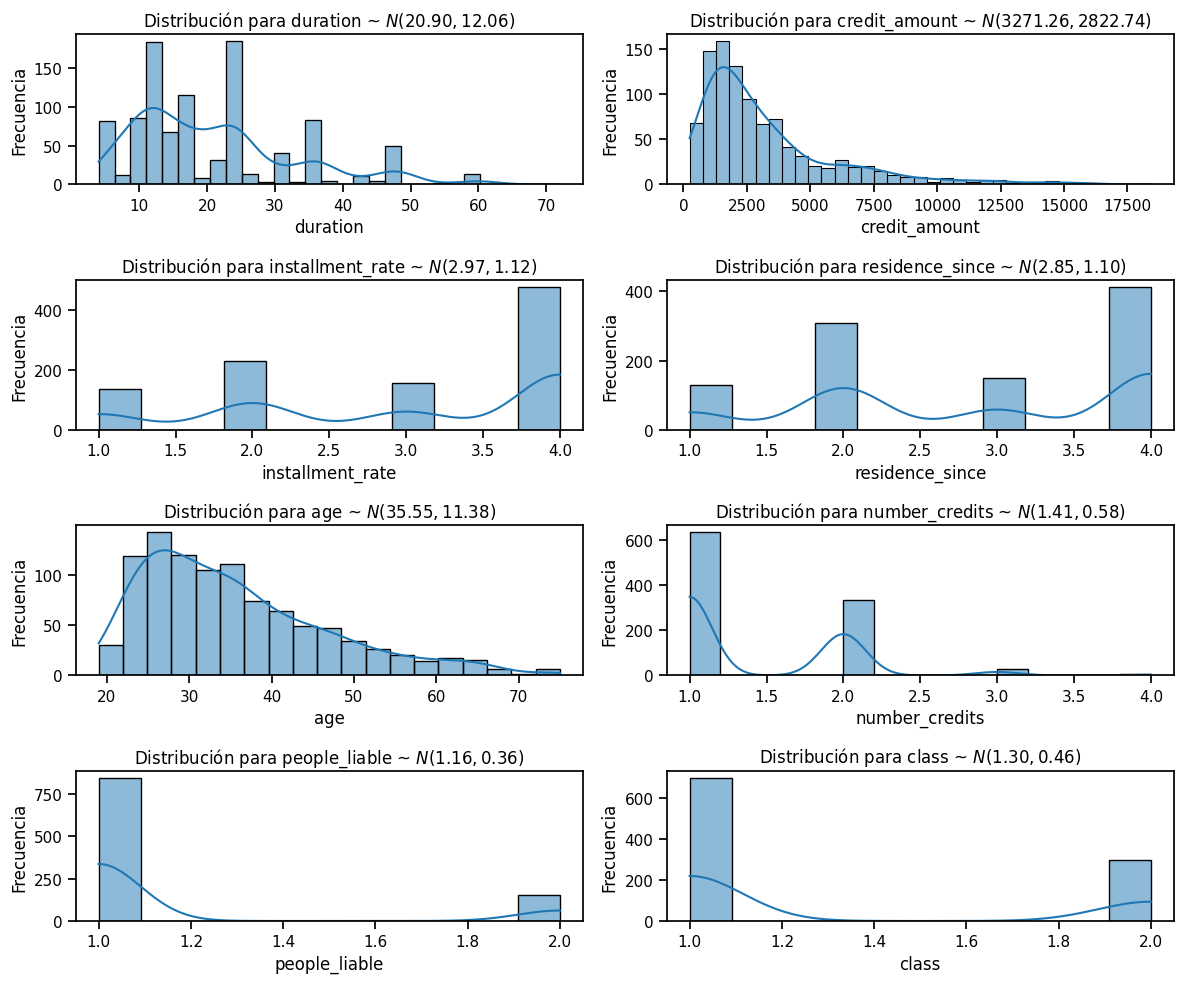

In [12]:
# Histogramas para cada variable de tipo numérica
fig, ax = plt.subplots(4, 2, figsize=(12, 10))
ax = ax.ravel()
numeric_attr = X.select_dtypes(include='number').columns.tolist()

for i, col in enumerate(numeric_attr):
    current_ax = ax[i]
    current_data = X[col]
    sns.histplot(data=current_data, kde=True, ax=current_ax)
    current_ax.set_title(f"Distribución para {col} ~ $N({current_data.mean():.2f}, {current_data.std():.2f})$")
    current_ax.set_xlabel(col)
    current_ax.set_ylabel("Frecuencia")

current_ax = ax[-1]
col = "class"
current_data = y[col]
sns.histplot(data=current_data, kde=True, ax=current_ax)
current_ax.set_title(f"Distribución para {col} ~ $N({current_data.mean():.2f}, {current_data.std():.2f})$")
current_ax.set_xlabel(col)
current_ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

**Observaciones sobre las variables numéricas:**

- **`duration`**: La duración media del crédito es de aproximadamente 21 meses, con un rango de 4 a 72 meses.
- **`credit_amount`**: El monto promedio de crédito es de 3,271 DM, con una variabilidad considerable (desviación estándar de 2,823 DM).
- **`age`**: La edad promedio de los solicitantes es de 35.5 años, con un mínimo de 19 y un máximo de 75 años.
- **`installment_rate`**: La tasa de pago promedio es de aproximadamente 3 (en porcentaje del ingreso disponible).
- **`class`**: La variable objetivo tiene un valor medio de 1.3, lo que indica que aproximadamente el 30% de los préstamos están clasificados como de alto riesgo (valor 2).

#### 2.1.1 Relación con la variable objetivo

Exploramos cómo las variables numéricas se relacionan con la clasificación de riesgo crediticio.

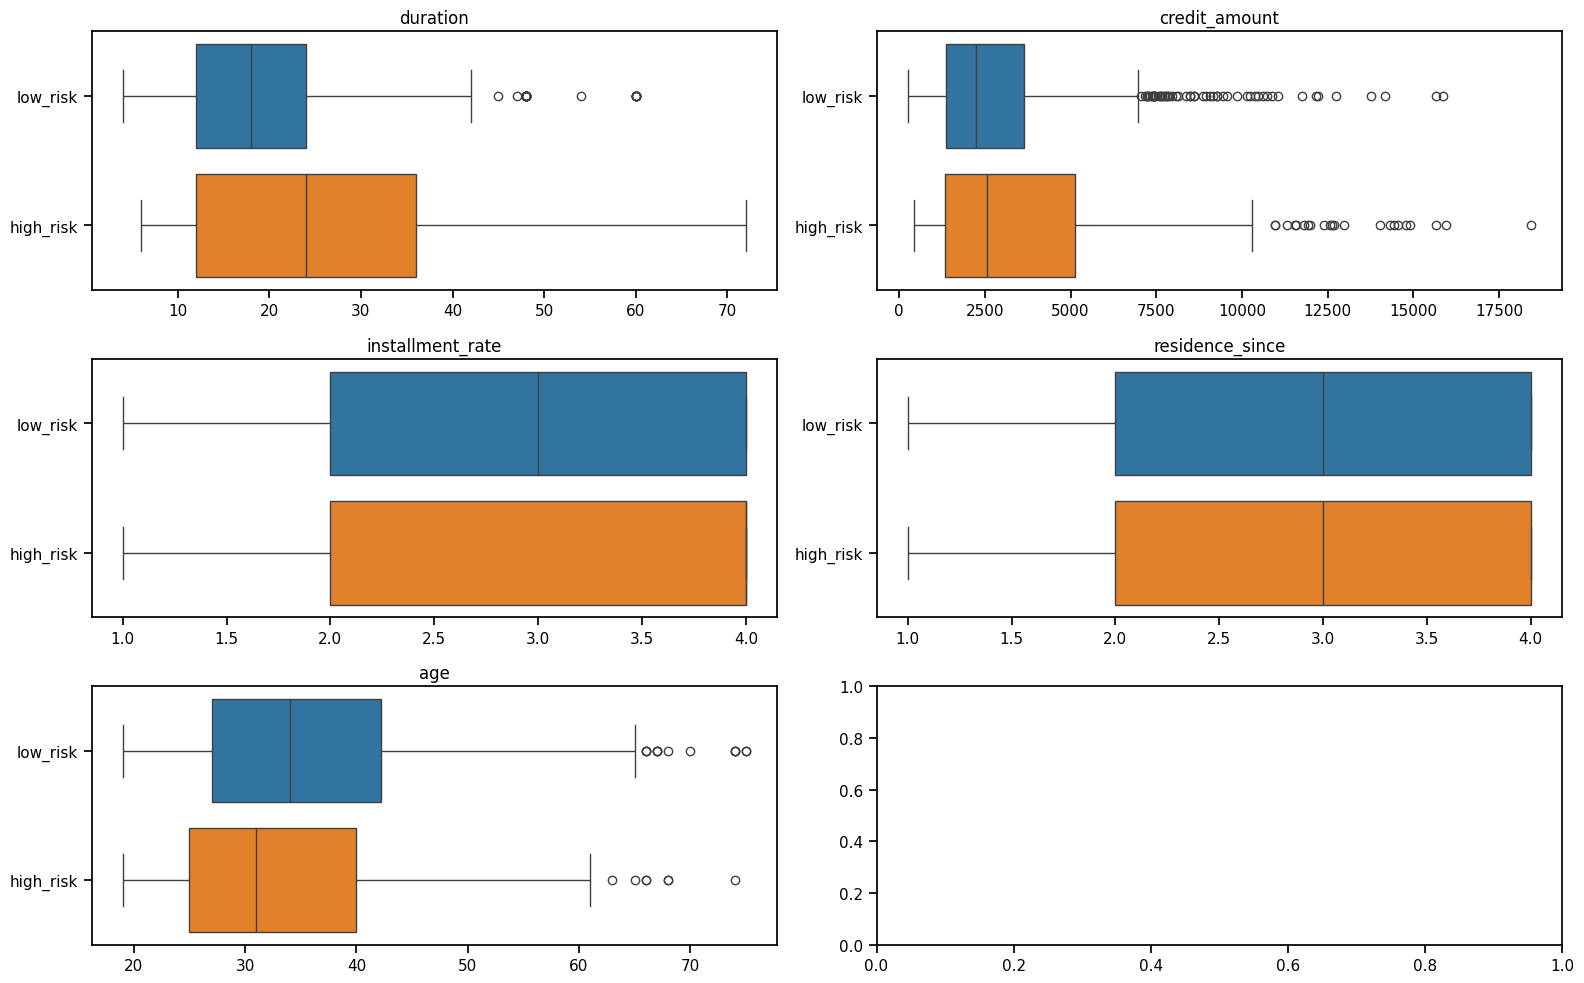

In [13]:
# Visualizaciones con box plots
fig, ax = plt.subplots(3, 2, figsize=(16, 10))
ax = ax.ravel()

for i, col in enumerate(numeric_attr):
    if col in ["number_credits", "people_liable"]:
        continue
    current_ax = ax[i]
    sns.boxplot(y=y["target"], x=X[col], ax=current_ax, hue=y["target"])
    current_ax.set_title(col)
    current_ax.set_ylabel("")
    current_ax.set_xlabel("")

plt.tight_layout()
plt.show()

**Análisis de la relación entre variables numéricas y riesgo crediticio:**

- **`duration`**: Los préstamos clasificados como de alto riesgo tienden a tener una duración mayor. Esto podría indicar que préstamos a más largo plazo se asocian con mayor probabilidad de incumplimiento.
- **`credit_amount`**: Los préstamos de alto riesgo suelen tener montos ligeramente más altos, aunque la diferencia no es tan marcada como en otras variables.
- **`age`**: Los solicitantes más jóvenes parecen ser clasificados como de alto riesgo con mayor frecuencia.
- **`installment_rate`**: Las tasas de pago más altas se asocian moderadamente con clasificaciones de alto riesgo.
- **`residence_since`**: No se observa una diferencia significativa entre las categorías de riesgo en función del tiempo de residencia.

### 2.2 Análisis de variables categóricas

Analizamos ahora las variables categóricas para entender su distribución y relación con la variable objetivo.

#### 2.2.1 Distribuciones y estadísticas

In [14]:
X.describe(include="object").T

,count,unique,top,freq
checking_account,1000,4,no account,394
credit_history,1000,5,paid duly till now,530
purpose,1000,10,radio/TV,280
savings_account,1000,5,< 100 DM,603
employment_since,1000,5,1 <= ... < 4 years,339
personal_status_sex,1000,4,"male, single",548
other_debtors,1000,3,none,907
property,1000,4,car / other,332
other_installment_plans,1000,3,none,814
housing,1000,3,own,713


**Observaciones sobre las variables categóricas:**

* **`credit_history`**: Al momento de solicitar un préstamo, un solicitante suele tener todos sus préstamos pagados debidamente.
* **`personal_status_sex`**: Los solicitantes son mayormente hombres solteros.
* **`housing`**: Los solicitantes en gran mayoría son dueños de la casa que habitan.
* **`job`**: Los solicitantes en gran mayoría tienen trabajos estables.
* **`foreign_worker`**: La mayoría son trabajadores extranjeros.

#### 2.2.2 Relación con la variable objetivo

In [15]:
categorical_attr = [
    "checking_account",
    "credit_history",
    "purpose",
    "savings_account",
    "employment_since",
    "housing",
    "job"
]

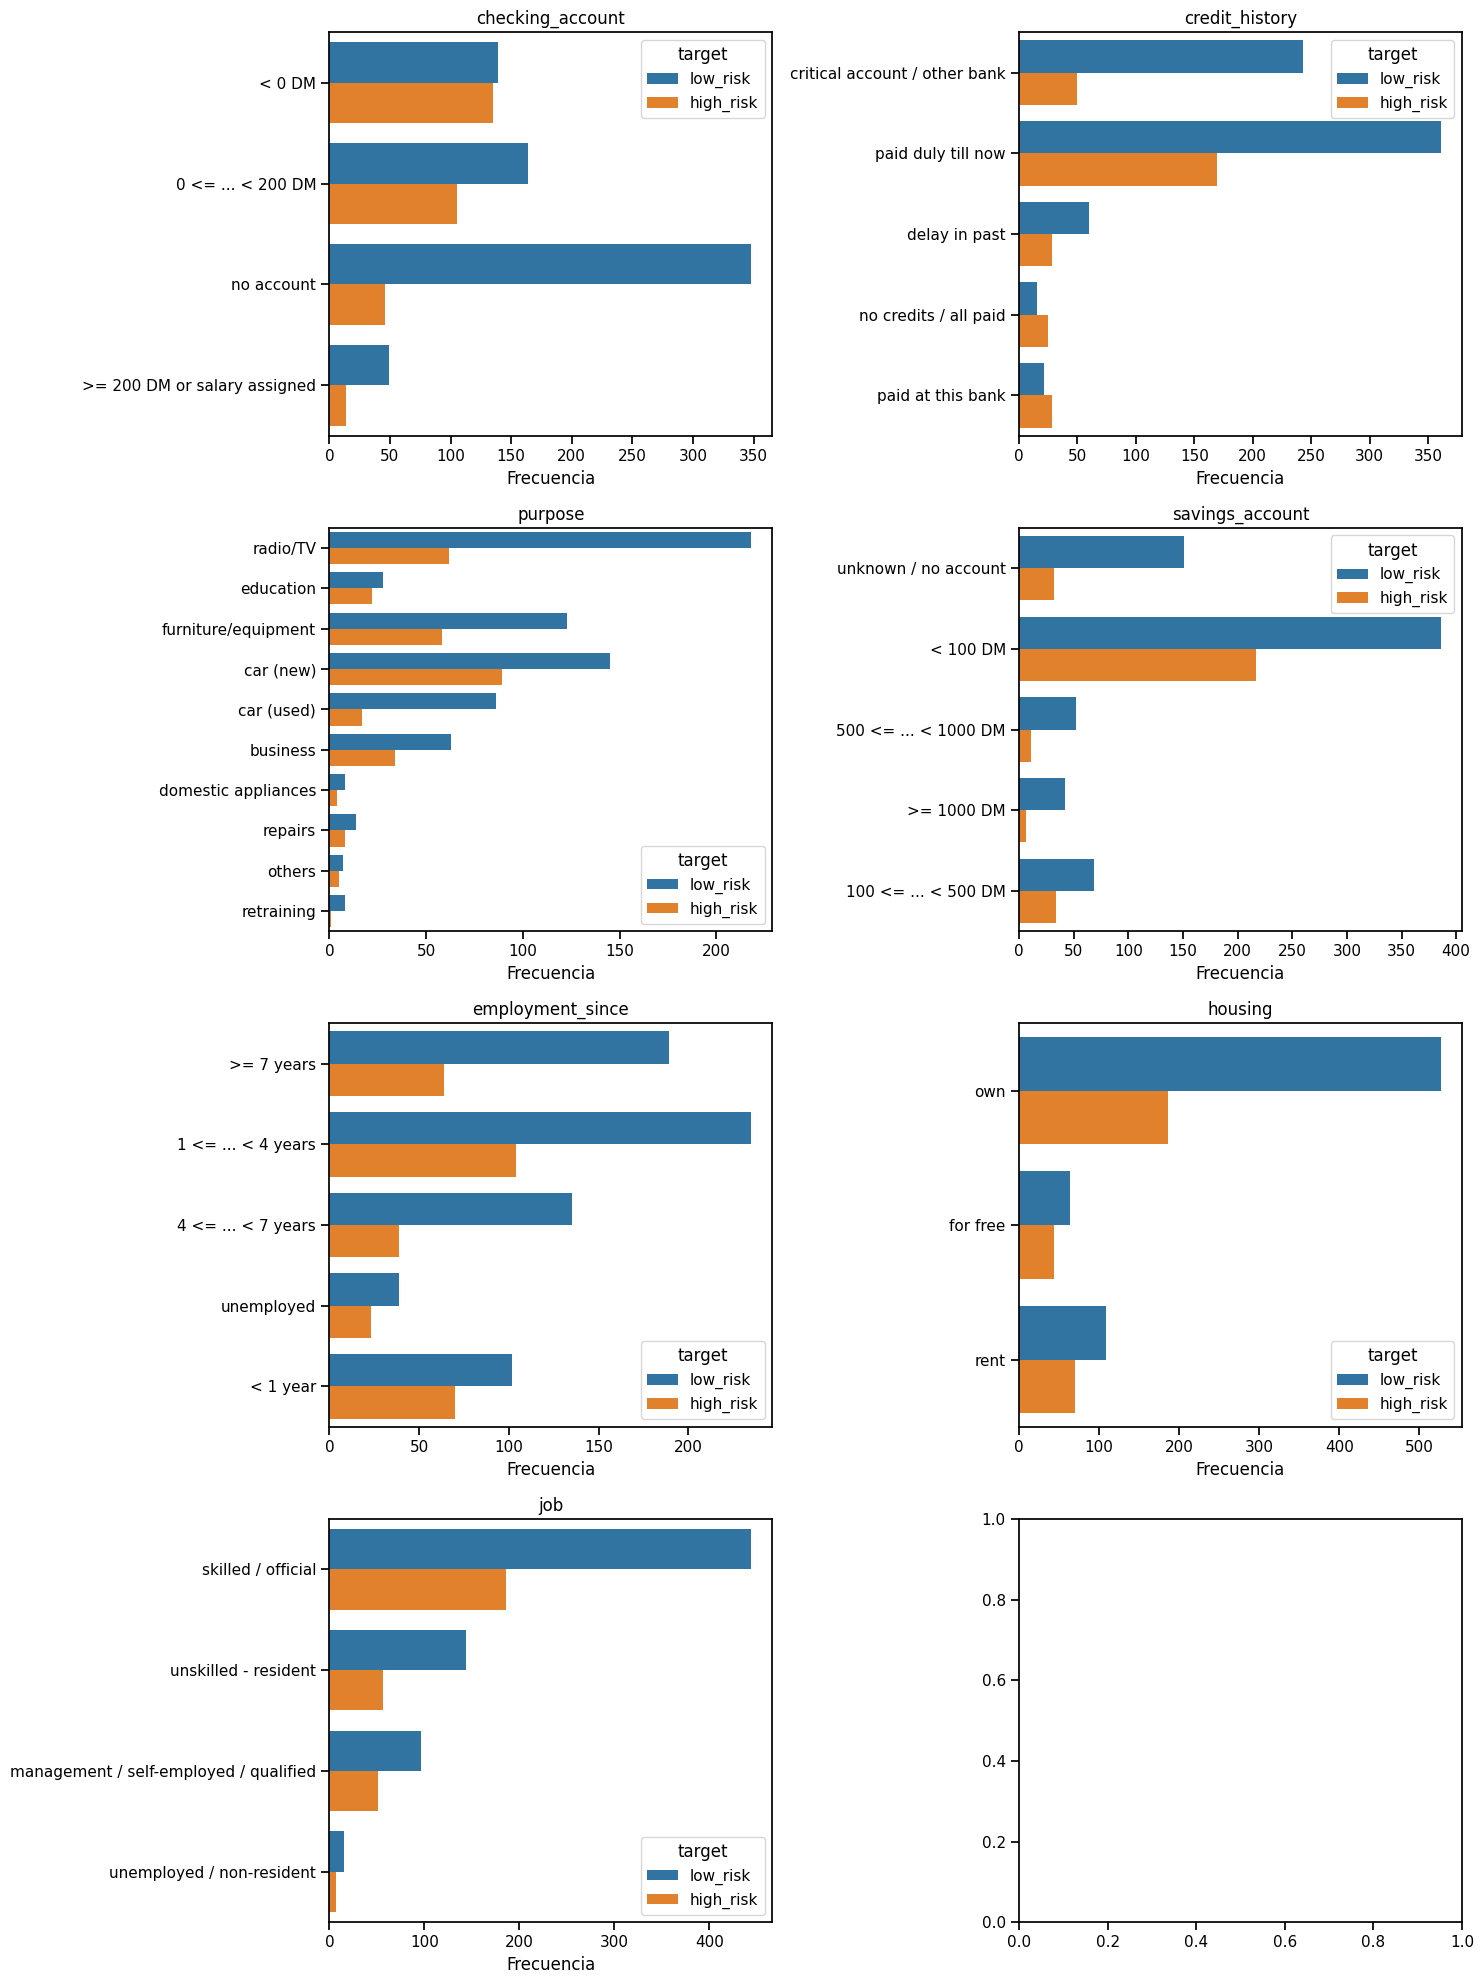

In [16]:
# Visualizaciones con count plots
fig, ax = plt.subplots(4, 2, figsize=(15, 20))
ax = ax.ravel()

for i, col in enumerate(categorical_attr):
    current_ax = ax[i]
    sns.countplot(y=X[col], hue=y["target"], ax=current_ax)
    current_ax.set_title(col)
    current_ax.set_ylabel("")
    current_ax.set_xlabel("Frecuencia")
    current_ax.legend(title="target", loc='best')

plt.tight_layout()
plt.show()

**Análisis de la relación entre variables categóricas y riesgo crediticio:**

* **`checking_account`**: Los solicitantes de bajo riesgo suelen no tener cuenta o tener saldos altos. Los de alto riesgo se concentran con saldos bajos.

* **`savings_account`**: En solicitantes con ahorros más bajos (<100 DM) suelen aparecer más de alto riesgo.

* **`employment_since`**: Mayor antigüedad laboral (≥ 4 años) se asocia a buen historial. Los que llevan menos de 1 año o están desempleados tienden a ser de alto riesgo.

* **`housing`**: La mayoría de los solicitantes de bajo riesgo son propietarios. Alquilar o vivir gratis es más común entre aquellos solicitantes clasificados como de alto riesgo si hablamos en términos de proporciones.

Con todos estos puntos en mente ya tenemos un análisis realizado sobre las variables presentes en nuestro conjunto de datos, logrando identificar aquellas más relevantes para la variable objetivo y aquellas que no tanto.

Ahora como último paso en este análisis exploratorio analizaremos más a fondo la variable que registra información sobre el género del solicitante.

### 2.3 Análisis de equidad por género

En esta sección, examinamos específicamente la distribución de género en los datos y su relación con la clasificación de riesgo crediticio, lo cual es fundamental para evaluar la equidad del modelo.

#### 2.3.1 Distribución por género

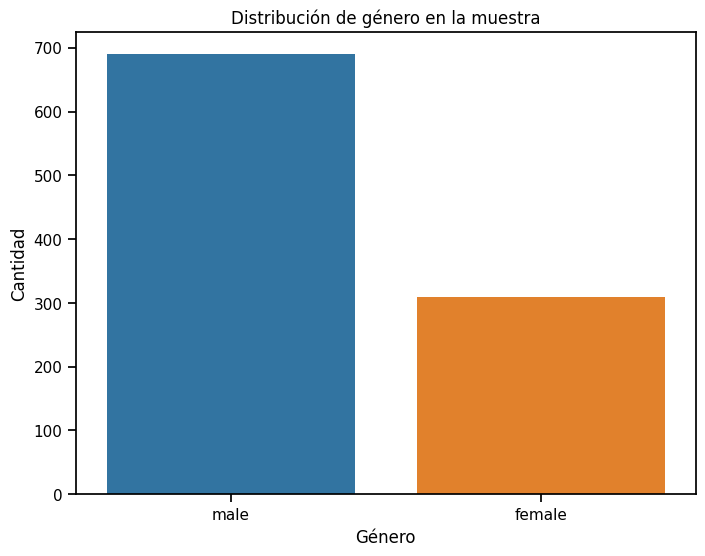

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=X, x="sex", hue="sex")
plt.title("Distribución de género en la muestra")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.show()

**Observaciones sobre la distribución de género:**

* Tenemos **una clara mayoría** del género masculino siendo en total 700 solicitantes de este género ante 300 del género femenino.

#### 2.3.2 Tasas de aprobación por género

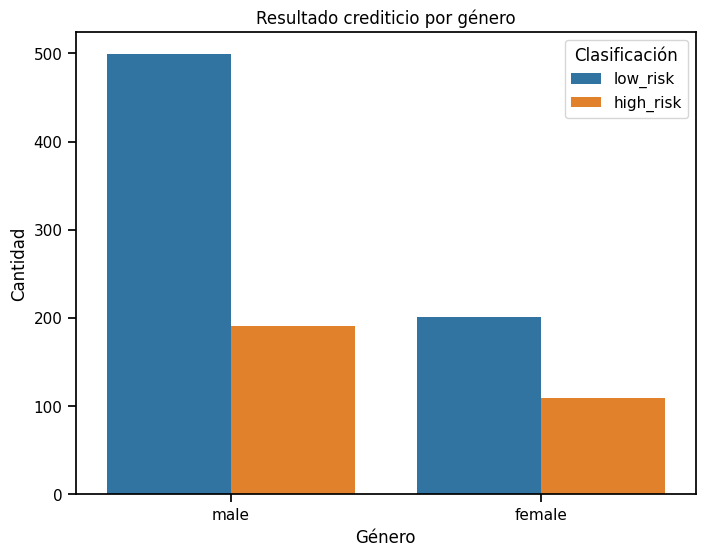

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x=X["sex"], hue=y["target"])
plt.title("Resultado crediticio por género")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.legend(title="Clasificación")
plt.show()

**Análisis de la relación género-riesgo:**

Podemos ver que en el género femenino la diferencia de proporciones entre el bajo o alto riesgo crediticio no está tan marcada como en el género masculino, donde la mayoría son clasificados como de bajo riesgo. Esto sugiere que en términos de proporciones, a las solicitantes femeninas se les suele clasificar como de alto riesgo con mayor frecuencia.

Veamos esto de las proporciones con un gráfico más específico:

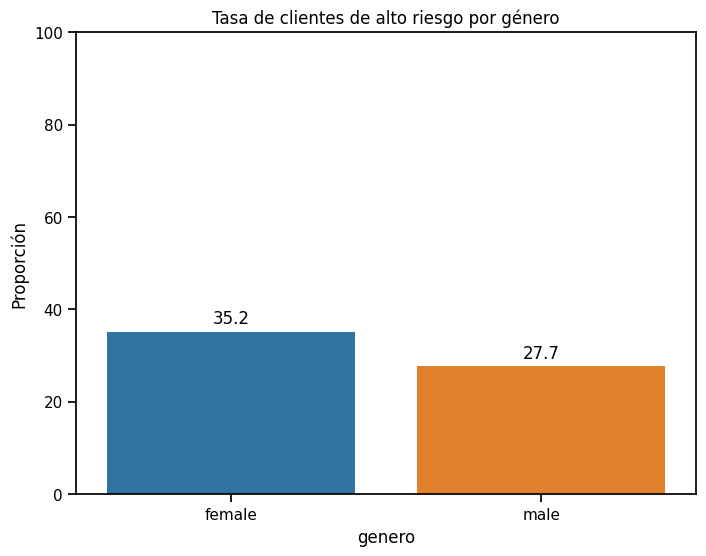

In [19]:
# Calculamos la tasa de alto riesgo por género
tasa_genero = X.copy()
tasa_genero["target"] = y["target"]
tasa_genero = tasa_genero.groupby("sex", observed=True)["target"].apply(lambda x: (x == "high_risk").mean()*100).reset_index()
tasa_genero.columns = ["genero", "proporcion"]

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=tasa_genero, x="genero", y="proporcion", hue="genero")
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)
plt.title("Tasa de clientes de alto riesgo por género")
plt.ylabel("Proporción")
plt.ylim(0, 100)
plt.show()

**Hallazgos importantes sobre equidad de género:**

A partir del gráfico y tabla anteriores, podemos ver que los solicitantes clasificados como de alto riesgo son en mayor proporción femeninos (como ya habíamos notado en los gráficos anteriores). Más precisamente, la diferencia es de aproximadamente 8 puntos porcentuales entre géneros:

- **Mujeres**: 35.2% clasificadas como alto riesgo
- **Hombres**: 27.7% clasificados como alto riesgo

Esta disparidad es significativa y plantea interrogantes importantes sobre equidad:
- ¿Existe un sesgo preestablecido entre las personas que generaron la clasificación originalmente?
- ¿Podremos evitar este posible sesgo en nuestro modelo predictivo?

### 2.4 Resumen del análisis exploratorio


1. **Variables numéricas relevantes:**
   - La duración del crédito muestra una clara relación con el riesgo. Los préstamos de mayor plazo tienden a ser clasificados como de mayor riesgo.
   - Solicitantes más jóvenes tienen mayor probabilidad de ser clasificados como de alto riesgo.
   - Montos de crédito más altos también se asocian moderadamente con clasificaciones de mayor riesgo.

2. **Variables categóricas importantes:**
   - Saldos bajos en la cuenta corriente es un fuerte predictor son asociados con alto riesgo.
   - Ahorros bajos (<100 DM) se asocian con clasificaciones de alto riesgo.
   - Menor antigüedad laboral (menos de 1 año) está relacionada con clasificaciones de alto riesgo.
   - Propietarios de vivienda tienen menor probabilidad de ser clasificados como de alto riesgo.

3. **Consideraciones de equidad:**
   - Existe una disparidad notable en las tasas de clasificación de alto riesgo entre géneros (35.2% para mujeres; 27.7% para hombres).
   - Esta diferencia de 8 puntos porcentuales plantea preocupaciones sobre posibles sesgos en la clasificación original.
   - Las variables relacionadas con ingresos, empleo y propiedad podrían estar actuando como proxies que amplifican disparidades de género.

In [20]:
# SEPARADOR ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# BORRAR PARA ENTREGA FINAL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ACÁ EMPIEZA LO QUE PERTENECE AL ARCHIVO 03_primer_modelo.ipynb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 3. Modelo _Baseline_

In [21]:
# Conversión de columnas tipo objeto a categóricas para mejor manejo
categorical_attr = X.select_dtypes(include=["object"]).columns
for col in categorical_attr:
    X[col] = X[col].astype("category")

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   checking_account         1000 non-null   category
 1   duration                 1000 non-null   int64   
 2   credit_history           1000 non-null   category
 3   purpose                  1000 non-null   category
 4   credit_amount            1000 non-null   int64   
 5   savings_account          1000 non-null   category
 6   employment_since         1000 non-null   category
 7   installment_rate         1000 non-null   int64   
 8   personal_status_sex      1000 non-null   category
 9   other_debtors            1000 non-null   category
 10  residence_since          1000 non-null   int64   
 11  property                 1000 non-null   category
 12  age                      1000 non-null   int64   
 13  other_installment_plans  1000 non-null   category
 14  housing  

### 3.1 Preparación de los datos para el entrenamiento

Llegamos a la prte de la preparación de datos para el entrenamiento de nuestro primer modelo. Entre los objetivos principales a lograr en esta sección tenemos:

* Llevar nuestros datos categóricos a un formato numérico mediante técnicas de encoding para poder usarlas en nuestro modelo.

* Realizar una **selección de variables** predictoras mediante el análisis de correlación respecto a la variable objetivo

* Sobre las variables seleccionadas **hacer una estandarización** de cara al entrenamiento del modelo.

* Separar los datos en conjuntos de entrenamiento y prueba.

#### 3.1.1 _One-Hot Encoding_ y análisis de correlación respecto al _target_

Primero, aplicaremos **_One-Hot Encoding_** a nuestro conjunto de datos para convertir todas las variables categóricas en un formato completamente numérico. Sin embargo, antes de hacerlo, eliminaremos un par de columnas cuya inclusión en este proceso resultaría **redundante**: **target_label** y **personal_status_sex**. A continuación, explicamos las razones para su exclusión:

* **personal_status_sex** contiene información combinada sobre el género y el estado civil de los solicitantes. Durante el análisis exploratorio, ya resumimos esta información en una nueva columna llamada **sex**, que indica únicamente si el solicitante es hombre o mujer. Consideramos que el estado civil no es relevante para los objetivos de este proyecto, por lo que **sex** contiene toda la información pertinente. Mantener **personal_status_sex** sería, por lo tanto, redundante.

* **target_label** fue una columna auxiliar creada durante el análisis exploratorio para facilitar la interpretación de las clases objetivo. Sin embargo, su información ya está representada en la columna **target**, por lo que no es necesario conservarla ni transformarla.

Por último, es importante aclarar una modificación que realizaremos en la columna **target**, la cual actualmente codifica el riesgo crediticio como **1 para bajo riesgo** y **2 para alto riesgo**. Para simplificar el modelado y facilitar la interpretación de los resultados, convertiremos estos valores a **1 para bajo riesgo crediticio** y **0 para alto riesgo crediticio**, siguiendo la convención habitual en problemas de clasificación binaria. Con todo esto aclarado procedemos a realizar los cambios:

In [22]:
# Eliminación de columnas innecesarias
df = X.drop(columns=["personal_status_sex"])

# Cambio de valores en columna 'class'
df["target"] = y["class"].map({1: 1, 2: 0})

# One-Hot Encoding de variables categóricas
df_dummies = pd.get_dummies(df)
df_dummies = df_dummies.astype(int)

print(f"Dimensiones del dataset: {df_dummies.shape[0]} filas × {df_dummies.shape[1]} columnas\n")
print("Primeras 5 filas:")
display(df_dummies.head())

Dimensiones del dataset: 1000 filas × 60 columnas

Primeras 5 filas:


,duration,credit_amount,installment_rate,residence_since,age,number_credits,people_liable,target,checking_account_0 <= ... < 200 DM,checking_account_< 0 DM,...,job_management / self-employed / qualified,job_skilled / official,job_unemployed / non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered",foreign_worker_no,foreign_worker_yes,sex_female,sex_male
0,6,1169,4,4,67,2,1,1,0,1,...,0,1,0,0,0,1,0,1,0,1
1,48,5951,2,2,22,1,1,0,1,0,...,0,1,0,0,1,0,0,1,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,0,1,1,0,0,1,0,1
3,42,7882,2,4,45,1,2,1,0,1,...,0,1,0,0,1,0,0,1,0,1
4,24,4870,3,4,53,2,2,0,0,1,...,0,1,0,0,1,0,0,1,0,1


Ya con nuestros datos en un formato numérico podemos proceder con el **análisis de correlación** que nos ayudará a elegir variables predictoras para nuestro modelo. Procedemos a observar las correlaciones respecto a la variable objetivo:

In [23]:
correlaciones = df_dummies.corr()["target"].sort_values(ascending=False)
print("Correlaciones con la variable 'target':")
print(correlaciones)

Correlaciones con la variable 'target':
target                                           1.000000
checking_account_no account                      0.322436
credit_history_critical account / other bank     0.181713
housing_own                                      0.134589
savings_account_unknown / no account             0.129238
property_real estate                             0.119300
other_installment_plans_none                     0.113285
purpose_radio/TV                                 0.106922
purpose_car (used)                               0.099791
age                                              0.091127
savings_account_>= 1000 DM                       0.085749
foreign_worker_no                                0.082079
employment_since_4 <= ... < 7 years              0.075980
sex_male                                         0.075493
savings_account_500 <= ... < 1000 DM             0.070954
employment_since_>= 7 years                      0.059733
other_debtors_guarantor         

Podemos ver en valores numéricos concretos cosas que **habíamos notado antes en el análisis exploratorio**: 

* La duración de un préstamo tiene una correlación negativa respecto a la variable objetivo, es decir que los solicitantes de alto riesgo solicitan préstamos de mayor duración.

* La presencia o ausencia de cuentas de ahorro/corriente tienen fuerte correlación en ambos sentidos con respecto a la variable objetivo.

Y así muchas otras relaciones observadas anteriormente en el análisis exploratorio podemos observar que aquí se cumplen.

Ahora con el objetivo de reducir el ruido y construir un modelo base más simple pero efectivo, aplicaremos un criterio básico de **selección de variables basado en la correlación** con la variable objetivo. En concreto, seleccionaremos aquellas variables que presenten una **correlación en valor absoluto mayor a 0.1** respecto de la variable **target**.

Este umbral fue elegido de manera pragmática: aunque no es alto, permite filtrar aquellas variables que tienen una **relación débil o inexistente con la variable objetivo**, sin ser demasiado restrictivo. De esta forma, eliminamos variables irrelevantes que podrían introducir ruido o redundancia en el modelo, al tiempo que conservamos aquellas que muestran al menos un **grado mínimo de asociación lineal** con el resultado que se desea predecir.
Procedemos a realizar dicha selección:

In [24]:
# Selección de variables con correlación significativa
variables_seleccionadas = correlaciones[abs(correlaciones) > 0.1].index.tolist()
variables_seleccionadas.append("sex_male")
variables_seleccionadas.remove("target")

# Df para mostrar las variables seleccionadas junto con su correlacion
df_seleccionadas = pd.DataFrame(correlaciones[variables_seleccionadas])
df_seleccionadas = df_seleccionadas.reset_index()
df_seleccionadas.columns = ["variable", "correlacion"]
df_seleccionadas = df_seleccionadas.sort_values(by="correlacion", ascending=False)
print("Variables seleccionadas y su correlación con la variable 'target':")
df_seleccionadas

Variables seleccionadas y su correlación con la variable 'target':


,variable,correlacion
0,checking_account_no account,0.322436
1,credit_history_critical account / other bank,0.181713
2,housing_own,0.134589
3,savings_account_unknown / no account,0.129238
4,property_real estate,0.119300
5,other_installment_plans_none,0.113285
6,purpose_radio/TV,0.106922
16,sex_male,0.075493
7,employment_since_< 1 year,-0.106397
8,checking_account_0 <= ... < 200 DM,-0.119581


Como último comentario queríamos mencionar el hecho de que incluimos a la variable que registra el género entre las seleccionadas, por más que esta no tuviese una alta correlación entendemos que esta es la pieza central en el desarrollo del modelo.

#### 3.1.2 Estandarización y separación en datos de entrenamiento y prueba

Prepararemos los datos para el entrenamiento de nuestro modelo. Esto implica:

1. Volver a separar variables predictoras (X) de la variable objetivo (y)
2. Dividir los datos en conjuntos de entrenamiento y prueba
3. Estandarizar las variables predictoras (X) de entrenamiento y prueba

In [25]:
# Separamos variables predictoras (X) y variable objetivo (y)
X = df_dummies[variables_seleccionadas]
y = df_dummies["target"]
idxs = X.index

# Dividimos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X.values, y.values, idxs, test_size=0.2, random_state=42
)

# Estandarizamos las variables predictoras
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostramos las dimensiones de los conjuntos de entrenamiento y prueba
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Distribución de clases en el conjunto de entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en el conjunto de prueba: {np.bincount(y_test)}")

Dimensiones de X_train: (800, 17)
Dimensiones de X_test: (200, 17)
Distribución de clases en el conjunto de entrenamiento: [241 559]
Distribución de clases en el conjunto de prueba: [ 59 141]


### 3.2 Entrenamiento del modelo de regresión logística

Utilizaremos un modelo de regresión logística como nuestro modelo base debido a:

1. **Simplicidad e interpretabilidad**: La regresión logística es un modelo sencillo
   cuyos coeficientes pueden interpretarse directamente, facilitando el análisis de equidad.

2. **Adecuación al problema**: Al ser un problema de clasificación binaria (alto/bajo riesgo),
   la regresión logística es una opción natural y efectiva.

3. **Eficiencia computacional**: Requiere menos recursos y tiempo de entrenamiento
   que modelos más complejos, lo que es ideal para una primera iteración.

Procedemos al entrenamiento de este modelo:

In [26]:
# Entrenamos y obtenemos predicciones para test
baseline_model = LogisticRegression(random_state=42, max_iter=1000, fit_intercept=True)
baseline_model.fit(X_train_scaled, y_train)

y_pred_test = baseline_model.predict(X_test_scaled)

### 3.3 Evaluación del modelo mediante métricas de clasificación

Evaluaremos el desempeño del modelo utilizando métricas estándar de clasificación:

- **Precisión (Precision)**: Proporción de predicciones positivas que fueron correctas
- **Sensibilidad (Recall)**: Proporción de casos positivos reales que fueron correctamente identificados
- **F1-Score**: Media armónica de precisión y sensibilidad
- **Exactitud (Accuracy)**: Proporción total de predicciones correctas

Estas métricas nos darán una visión general de la calidad del modelo y su capacidad
para identificar correctamente tanto solicitantes de bajo como de alto riesgo.

In [27]:
print("Reporte de clasificación para el Modelo Baseline\n\n", classification_report(y_test, y_pred_test))

Reporte de clasificación para el Modelo Baseline

               precision    recall  f1-score   support

           0       0.66      0.42      0.52        59
           1       0.79      0.91      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



#### 3.3.1 Análisis de las métricas

- **Clase 1 (Bajo riesgo)**: El modelo muestra un buen desempeño identificando solicitantes de bajo riesgo:
  - Precisión: 0.79 - El 79% de los solicitantes clasificados como bajo riesgo efectivamente lo son.
  - Sensibilidad: 0.91 - El modelo identifica correctamente el 91% de los solicitantes de bajo riesgo.
  - F1-Score: 0.84 - Buen balance entre precisión y sensibilidad para esta clase.

- **Clase 0 (Alto riesgo)**: El desempeño es menor para identificar solicitantes de alto riesgo:
  - Precisión: 0.66 - El 66% de los solicitantes clasificados como alto riesgo realmente lo son.
  - Sensibilidad: 0.42 - El modelo solo identifica correctamente el 42% de los solicitantes de alto riesgo.
  - F1-Score: 0.52 - Desempeño bajo/moderado para esta clase.

- **Exactitud general**: 0.77 - El 77% de todas las predicciones son correctas.

Este desequilibrio en el desempeño entre clases podría atribuirse principalmente a la
distribución desbalanceada de las clases en los datos, donde hay más solicitantes de
bajo riesgo que de alto riesgo. Esta situación es común en problemas de crédito y
requiere atención especial desde la perspectiva de equidad.

### 3.4 Matriz de confusión

La matriz de confusión nos permitirá visualizar en detalle los aciertos y errores del modelo,
así como entender los diferentes tipos de errores (falsos positivos y falsos negativos) y su
impacto en términos de equidad y toma de decisiones.

In [28]:
def graficar_matrices_de_confusion(matrices, n_rows:int=1, n_cols:int=1, size:tuple=(10, 6)):
    # Visualizamos las matrices de confusión
    _, ax = plt.subplots(n_rows, n_cols, figsize=size)
    labels = ['Bajo riesgo (1)', 'Alto riesgo (0)']
    if isinstance(ax, np.ndarray):
        ax = ax.ravel()
    else:
        ax = [ax]  # convertimos Axes a lista

    i = 0
    for titulo, matriz in matrices.items():
        current_ax = ax[i]

        # Cada uno de los heatmaps
        sns.heatmap(
            matriz,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=current_ax,
            cbar=False,
            xticklabels=labels,
            yticklabels=labels
        )

        # Agrego labels de referencia para mayor claridad
        for (j, k), val in np.ndenumerate(matriz):
            if j == 0 and k == 0:
                label = "TP"
            elif j == 1 and k == 0:
                label = "FP"
            elif j == 0 and k == 1:
                label = "FN"
            else:
                label = "TN"
            current_ax.text(
                k + 0.35, j + 0.5,
                label,
                color="black",
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold"
            )

        #  Configuraciones de labels
        current_ax.set_title(titulo)
        current_ax.set_xlabel("Predicción")
        current_ax.set_ylabel("Valor Real")
        i = i+1

    plt.tight_layout()
    plt.show()

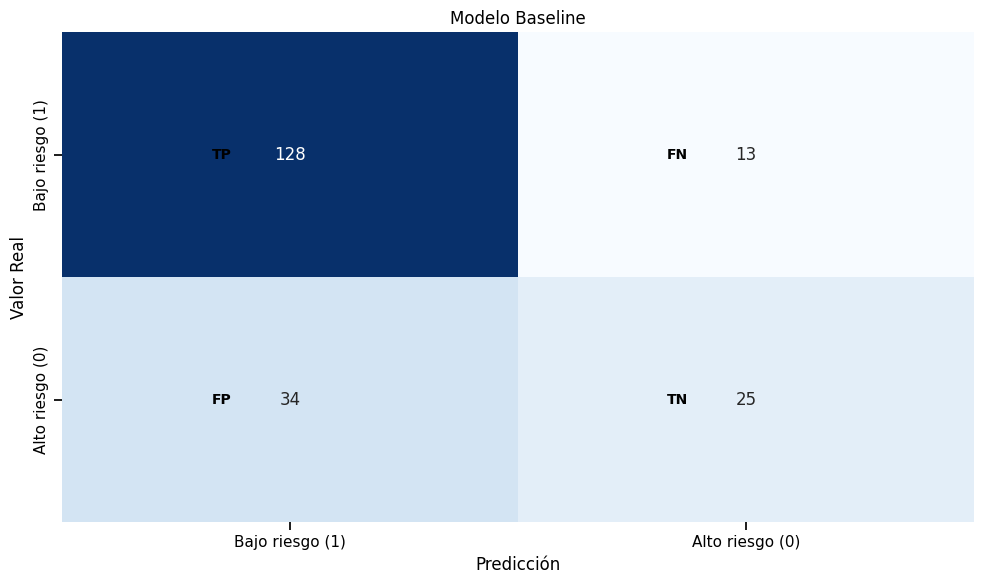

In [29]:
graficar_matrices_de_confusion({"Modelo Baseline": confusion_matrix(y_test, y_pred_test, labels=[1, 0])})

#### 3.4.1 Análisis de la matriz de confusión

Para interpretar correctamente la matriz, consideremos:

- **Verdaderos positivos (TP)**: 128 solicitantes fueron correctamente clasificados como de bajo riesgo.
- **Falsos negativos (FN)**: 13 solicitantes de bajo riesgo fueron incorrectamente clasificados como de alto riesgo.
- **Falsos positivos (FP)**: 34 solicitantes de alto riesgo fueron incorrectamente clasificados como de bajo riesgo.
- **Verdaderos negativos (TN)**: 25 solicitantes fueron correctamente clasificados como de alto riesgo.

**Implicaciones de los errores**:

1. **Falsos positivos (34)**: Este tipo de error es particularmente problemático para instituciones financieras, ya que implica otorgar préstamos a personas que realmente son de alto riesgo, lo que podría resultar en pérdidas financieras.

2. **Falsos negativos (13)**: Aunque menos costoso desde la perspectiva financiera, este error implica negar préstamos a personas que realmente son de bajo riesgo, lo que representa un problema de equidad y acceso a servicios financieros.

El balance entre estos tipos de errores es fundamental para garantizar tanto la salud financiera de la institución como la equidad en el acceso al crédito para diferentes grupos demográficos.

In [30]:
# SEPARADOR ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# BORRAR PARA ENTREGA FINAL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ACÁ EMPIEZA LO QUE PERTENECE AL ARCHIVO 04_evaluacion_fairness.ipynb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 4. Evaluación de equidad por género
### 4.1 Matriz de confusión y Métricas de rendimiento por género

Ahora vamos a analizar al atributo que consideramos sensible en este análisis, el género. Para esto vamos a separar el conjunto de datos entre la categoría femenina y masculina:

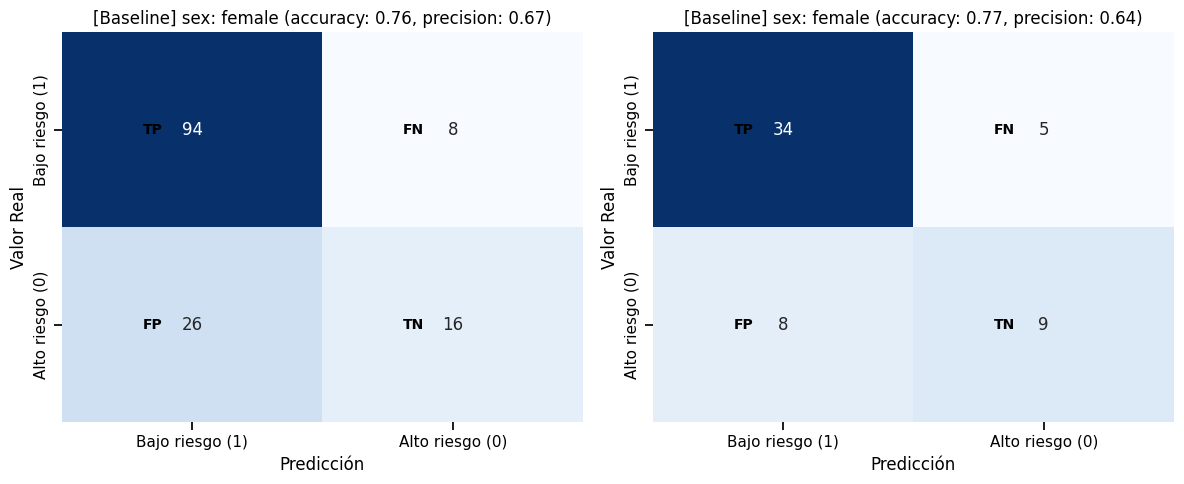

In [31]:
def accuracy_precision(cm):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return accuracy, precision

df_eval = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_test": y_pred_test,
        "sex": df.loc[idx_test, "sex"]
    }
)
df_male_eval = df_eval[df_eval["sex"] == "male"]
df_female_eval = df_eval[df_eval["sex"]  == "female"]

cm_male = confusion_matrix(
    df_male_eval["y_test"], df_male_eval["y_pred_test"], labels=[1, 0]
)
cm_female = confusion_matrix(
    df_female_eval["y_test"], df_female_eval["y_pred_test"], labels=[1, 0]
)
acc_male, prec_male = accuracy_precision(cm_male)
acc_female, prec_female = accuracy_precision(cm_female)
titulo_male = f"[Baseline] sex: female (accuracy: {acc_male:.2f}, precision: {prec_male:.2f})"
titulo_female = f"[Baseline] sex: female (accuracy: {acc_female:.2f}, precision: {prec_female:.2f})"

matrices_sex_eval = {
    titulo_male: cm_male,
    titulo_female: cm_female
}

graficar_matrices_de_confusion(matrices_sex_eval, n_rows=1, n_cols=2, size=(12, 5))

De este par de gráficos podemos notar lo siguiente:

* En ambas categorías el modelo logró identificar en la mayoría de los casos a los verdaderos positivos con 34 casos en la categoría femenina y 94 en la masculina.

* En la categoría masculina se obtuvo una mayor tasa de falsos positivos en términos de proporción a comparación de la categoría femenina, siendo que de un total de 42 casos de alto riesgo, 26 fueron falsos positivos y 16 verdaderos negativos.

* En la categoría femenina solamente se identificaron a 5 personas erróneamente como de alto riesgo, lo que indica que el modelo tuvo un buen desempeño identificando instancias positivas en esta clase.

Con estos puntos ya empezamos a notar cosas importantes acerca del desempeño del modelo entre los grupos, **pareciendo inicialmente que el modelo se desempeñó mejor en la clase femenina**.

Miremos ahora las métricas generales de clasificación para cada grupo:

In [32]:
print("Report de clasificación para sex: female (modelo baseline)\n\n", classification_report(df_female_eval["y_test"], df_female_eval["y_pred_test"]))
print("Report de clasificación para sex: male (modelo baseline)\n\n", classification_report(df_male_eval["y_test"], df_male_eval["y_pred_test"]))

Report de clasificación para sex: female (modelo baseline)

               precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.81      0.87      0.84        39

    accuracy                           0.77        56
   macro avg       0.73      0.70      0.71        56
weighted avg       0.76      0.77      0.76        56

Report de clasificación para sex: male (modelo baseline)

               precision    recall  f1-score   support

           0       0.67      0.38      0.48        42
           1       0.78      0.92      0.85       102

    accuracy                           0.76       144
   macro avg       0.72      0.65      0.67       144
weighted avg       0.75      0.76      0.74       144



Podemos ver que en términos de métricas calculadas no hay diferencias significativas entre ambos géneros, siendo que en casos como **accuracy general** ambas tuvieron puntajes casi similares e igual ocurre con las otras métricas. **¿Que implica esto en términos de equidad?**.

Para analizar esto aún más a profundidad vamos a hacer **pruebas de disparidad** entre ambos géneros para evaluar si el modelo está generando predicciones justas.

### 4.2 Evaluando según distintos enfoques del Group Fairness

En el contexto en el que nos encontramos, donde desarrollamos un modelo de aprendizaje automático que ayude en la asignación de créditos bancarios, es fundamental garantizar que las decisiones del sistema no estén sesgadas en función de atributos sensibles como el género. Un enfoque que nos ayudará a evaluar cuestiones relacionadas al sesgo por grupos es el **Group Fairness (equidad grupal)**, el cual permite evaluar si el modelo trata de manera equitativa a distintos grupos poblacionales definidos por atributos sensibles. 

Este enfoque se basa en comparar métricas de desempeño del modelo **—como tasas de verdaderos positivos, falsos positivos, precisión o tasa de aprobación—** entre los distintos grupos. Su relevancia radica en que ayuda a identificar **disparidades sistemáticas que podrían derivar en discriminación algorítmica**, afectando la transparencia, la justicia y, potencialmente, el cumplimiento normativo de la organización.

#### 4.2.1 Definiciones de métricas

Entre las principales definiciones de equidad según el enfoque de **Group Fairness**, se identifican **cuatro métricas clave**, que en nuestro caso pueden interpretarse de la siguiente manera:

* **Statistical Parity / Demographic Parity (Independencia): $\mathbb{P}(\hat{Y} = 1 | A =a) = \mathbb{P}(\hat{Y} = 1 | A =b)$:** En nuestro contexto, la clase positiva (1) representa a un solicitante con bajo riesgo crediticio. Este criterio busca que la proporción de personas clasificadas por el modelo como de bajo riesgo sea la misma en ambos grupos (géneros). Esto apunta a garantizar un acceso equitativo a decisiones favorables sin importar el grupo al que se pertenezca.

* **Equalized Odds (Separación): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$ $\text{ y }$ $\mathbb{P}(\hat{Y} = 1 |Y = 0, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 0, A =b)$:** Este criterio exige que el modelo tenga la misma tasa de verdaderos positivos (clasificar correctamente como de bajo riesgo) y de falsos positivos (clasificar como de bajo riesgo a quienes en realidad no lo son) para ambos grupos. Es decir, que el modelo acierte y se equivoque de forma similar para todos los grupos sensibles.

* **Equal Oportunity (Separación relajada): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$:** Es una versión más flexible de Equalized Odds. Se enfoca únicamente en la tasa de verdaderos positivos, buscando que el modelo identifique con la misma probabilidad como de bajo riesgo a las personas que realmente lo son, sin importar su grupo.

* **Predictive Parity (Suficiencia): $\mathbb{P}(Y= 1 |\hat{Y} =1, A =a) = \mathbb{P}(Y= 1 |\hat{Y} =1, A =b)$** Este criterio se centra en la precisión de las predicciones positivas. En nuestro caso, exige que, entre los solicitantes identificados por el modelo como de bajo riesgo, la proporción que realmente lo son sea igual en ambos grupos. Esto asegura que la confianza que se puede tener en una predicción favorable sea independiente del grupo sensible.

Teniendo en cuenta las definiciones anteriores, ya contamos con una idea clara de qué aspectos debemos medir para evaluar la equidad en cada caso. Para hacerlo, necesitamos recurrir a métricas específicas que se alineen con cada una de estas definiciones. A continuación, detallamos las métricas correspondientes:

* Para **Statistical Parity**, una métrica útil es **`pprev`**, que según la [documentación de Aequitas](https://dssg.github.io/aequitas/metrics.html), libreria dedicada a evaluar fairness, representa la proporción de instancias que el modelo clasifica como positivas (en nuestro caso, solicitantes de bajo riesgo) sobre el total de instancias de un grupo. Esta métrica refleja directamente la probabilidad condicional definida anteriormente.

* En el caso de **Equalized Odds**, las métricas relevantes son el **True Positive Rate (TPR)** y el **False Positive Rate (FPR)**. Para que se cumpla esta definición, ambos indicadores deben superar la prueba de disparidad, es decir, presentar valores similares entre los grupos.

* Para **Equal Opportunity**, nos enfocamos únicamente en el **True Positive Rate (TPR)**. Si esta métrica pasa la prueba de disparidad, se considera que la definición está satisfecha.

* Finalmente, para **Predictive Parity**, la métrica adecuada es la **precisión (precision)**, que mide qué proporción de las instancias clasificadas como positivas por el modelo (bajo riesgo) fueron realmente positivas en la realidad.

Con estas métricas definidas, podemos proceder a aplicar la prueba de disparidad entre los distintos grupos definidos por la variable de género.

### 4.3 Evaluación de disparidad

A continuación, utilizamos las métricas definidas previamente para evaluar la equidad del modelo en función del **género**. Para ello primero obtenemos sus valores puntuales para este caso:

In [33]:
resultados = []

for grupo, categoria in df_eval.groupby("sex", observed=False):
    # Verdaderos positivos y falsos positivos
    tp = ((categoria["y_test"] == 1) & (categoria["y_pred_test"] == 1)).sum()
    fp = ((categoria["y_test"] == 0) & (categoria["y_pred_test"] == 1)).sum()

    total = len(categoria)
    positivos_reales = (categoria["y_test"] == 1).sum()
    negativos_reales = (categoria["y_test"] == 0).sum()
    predichos_positivos = (categoria["y_pred_test"] == 1).sum()

    # Métricas
    pprev = predichos_positivos / total if total else 0
    tpr = tp / positivos_reales if positivos_reales else 0
    fpr = fp / negativos_reales if negativos_reales else 0
    precision = tp / (tp + fp) if (tp + fp) else 0

    resultados.append({
        "Atributo": grupo,
        "Predicted Positive": pprev,
        "True Positive Rate": tpr,
        "False Positive Rate": fpr,
        "Precision": precision
    })

results_df = pd.DataFrame(resultados).round(5)
results_df

,Atributo,Predicted Positive,True Positive Rate,False Positive Rate,Precision
0,female,0.75000,0.87179,0.47059,0.80952
1,male,0.83333,0.92157,0.61905,0.78333


Para evaluar la equidad del modelo en términos de *Group Fairness*, decidimos adoptar como criterio de disparidad una diferencia máxima tolerable de **0.1** (en valor absoluto) entre las métricas de equidad de ambos géneros. Este umbral se fundamenta en tres consideraciones:

* **Interpretabilidad práctica**: diferencias mayores al 10% en métricas como la tasa de verdaderos positivos o la tasa de aprobación pueden implicar efectos sustanciales y sistemáticos sobre el acceso a beneficios (como créditos, becas o servicios), y por lo tanto, pueden considerarse potencialmente injustas o discriminatorias desde una perspectiva de impacto social.

* **Balance entre equidad y performance**: un umbral de 0.1 nos permite mantener un buen compromiso entre reducir el sesgo y no afectar excesivamente la capacidad predictiva del modelo. Umbrales más estrictos podrían forzar al modelo a sacrificar demasiado rendimiento, mientras que valores más permisivos podrían ignorar desigualdades sustanciales.

En este análisis, entonces, **consideramos como aceptable toda diferencia en módulo menor o igual a 0.1**. Si alguna métrica clave supera dicho umbral, interpretamos que hay indicios de sesgo que deben ser luego mitigados.

In [34]:
# Seleccionamos solo las columnas numéricas (excluyendo 'attribute_value')
columnas_numericas = results_df.select_dtypes(include="number").columns.tolist()

# Calculamos la diferencia absoluta entre las dos filas
modulo_diferencias = (results_df.loc[0, columnas_numericas] - results_df.loc[1, columnas_numericas]).abs()

# Mostramos el resultado
print(modulo_diferencias)

Predicted Positive     0.08333
True Positive Rate     0.04978
False Positive Rate    0.14846
Precision              0.02619
dtype: object


A partir de las diferencias obtenidas tenemos que:

* **Demographic Parity** (`pprev`: 0.0833): **cumple**
* **Predictive Parity** (`precision`: 0.0261): **cumple**
* **Equalized Odds**:

  * `tpr`: 0.0497 → **cumple** **(Equal Oportunity)**
  * `fpr`: 0.1485 → **no cumple**

Por lo tanto, el modelo **no cumple con Equalized Odds**, ya que comete más errores (falsos positivos) en un grupo que en el otro. Sin embargo nunca está de más destacar el buen desempeño 
general que tuvo nuestro modelo con las 4 métricas consideradas. 

Ahora pensando desde la perspectiva del equipo que forma parte del banco que otorga los créditos, sabemos que nuestro objetivo principal es **maximizar la cantidad de personas que efectivamente van a pagar el préstamo**. Desde esta perspectiva, **Equalized Odds** es la definición de equidad que mejor se alinea con nuestra meta institucional, ya que:

* Controla a los verdaderos positivos, procurando que ambos grupos tengan tasas similares en esta métrica e **identificando correctamente a personas que podrán pagar**.

* Evita otorgar créditos a quienes no podrán pagarlos **ya que toma en cuenta también a los falsos positivos**, protegiendo la sustentabilidad del sistema.

Teniendo esto en cuenta, y dado que observamos una disparidad en la tasa de falsos positivos entre grupos, el próximo paso será desarrollar un modelo que mitigue este sesgo y nos permita cumplir con la definición de **Equalized Odds** en nuestro caso de asignación de créditos.

In [35]:
# SEPARADOR ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# BORRAR PARA ENTREGA FINAL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ACÁ EMPIEZA LO QUE PERTENECE AL ARCHIVO 05_modelo_mitigado.ipynb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## 5. Mitigación de sesgo del modelo _baseline_

In [36]:
metrics = {}

X_train_df = pd.DataFrame(X_train, index=idx_train, columns=variables_seleccionadas)
X_test_df = pd.DataFrame(X_test, index=idx_test, columns=variables_seleccionadas)

baseline_metrics = classification_bias_metrics(
    X_test_df["sex_male"] == 1,
    X_test_df["sex_male"] == 0,
    y_pred_test,
    y_test,
    metric_type="both",
)

baseline_accuracy = accuracy_score(y_test, y_pred_test)

metrics["Baseline"] = baseline_metrics
print(baseline_metrics)
print(f"Baseline accuracy: {baseline_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

                                       Value  Reference
Metric                                                 
Statistical Parity                  0.083333          0
Disparate Impact                    1.111111          1
Four Fifths Rule                    0.900000          1
Cohen D                             0.213470          0
2SD Rule                            1.348838          0
Equality of Opportunity Difference  0.049774          0
False Positive Rate Difference      0.148459          0
Average Odds Difference             0.099117          0
Accuracy Difference                -0.003968          0
Baseline accuracy: 0.7650
              precision    recall  f1-score   support

           0       0.66      0.42      0.52        59
           1       0.79      0.91      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



### 5.1 Primer método de mitigación

#### 5.1.1 Aplicación de `CorrelationRemover()` y entrenamiento

In [37]:
corr_remover = CorrelationRemover()

pipe_corr_remover = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("bm_preprocessing", corr_remover),
        ("estimator", baseline_model),
    ]
)

pipe_corr_remover.fit(
    X_train,
    y_train,
    bm__group_a=X_train_df["sex_male"] == 1,
    bm__group_b=X_train_df["sex_male"] == 0,
)

y_pred_test_corr_remover = pipe_corr_remover.predict(
    X_test, bm__group_a=X_test_df["sex_male"] == 1, bm__group_b=X_test_df["sex_male"] == 0
)

metrics_preprocessing_correlation_remover = classification_bias_metrics(
    X_test_df["sex_male"] == 1,
    X_test_df["sex_male"] == 0,
    y_pred_test_corr_remover,
    y_test,
    metric_type="both",
)

metrics["CorrelationRemover"] = metrics_preprocessing_correlation_remover
print(metrics_preprocessing_correlation_remover)

                                       Value  Reference
Metric                                                 
Statistical Parity                 -0.097222          0
Disparate Impact                    0.888889          1
Four Fifths Rule                    0.888889          1
Cohen D                            -0.246777          0
2SD Rule                           -1.558155          0
Equality of Opportunity Difference -0.056561          0
False Positive Rate Difference     -0.205882          0
Average Odds Difference            -0.131222          0
Accuracy Difference                 0.027778          0


#### 5.1.2 Evaluación con métricas de clasificación

In [38]:
print("Reporte de clasificación CorrelationRemover\n\n", classification_report(y_test, y_pred_test_corr_remover))

Reporte de clasificación CorrelationRemover

               precision    recall  f1-score   support

           0       0.67      0.44      0.53        59
           1       0.80      0.91      0.85       141

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.69       200
weighted avg       0.76      0.77      0.75       200



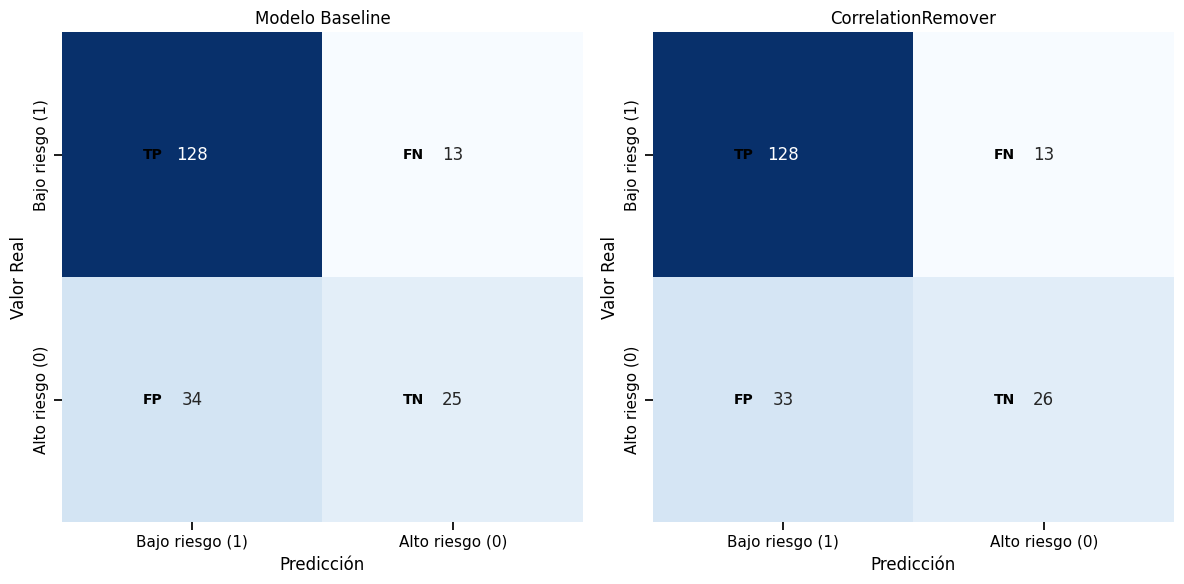

In [39]:
graficar_matrices_de_confusion(
    {"Modelo Baseline": confusion_matrix(y_test, y_pred_test, labels=[1, 0]),
     "CorrelationRemover": confusion_matrix(
        y_test, y_pred_test_corr_remover, labels=[1, 0]
    )},
    n_cols=2,
    size=(12, 6)
)

### 5.2 Segundo método de mitigación

#### 5.2.1 Aplicación de `PrejudiceRemover()` y entrenamiento

In [40]:
prejud_remover = PrejudiceRemover(
    maxiter=100, fit_intercept=True, print_interval=1
)

pipe_prejud_remover = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("bm_inprocessing", prejud_remover.transform_estimator(baseline_model)),
    ]
)

pipe_prejud_remover.fit(
    X_train,
    y_train,
    bm__group_a=X_train_df["sex_male"] == 1,
    bm__group_b=X_train_df["sex_male"] == 0,
)

y_pred_test_prejud_remover = pipe_prejud_remover.predict(
    X_test, bm__group_a=X_test_df["sex_male"] == 1, bm__group_b=X_test_df["sex_male"] == 0
)

metrics_prejud_remover = classification_bias_metrics(
    X_test_df["sex_male"] == 1,
    X_test_df["sex_male"] == 0,
    y_pred_test_prejud_remover,
    y_test,
    metric_type="both",
)

metrics["PrejudiceRemover"] = metrics_prejud_remover
print(metrics_prejud_remover)

                                       Value  Reference
Metric                                                 
Statistical Parity                 -0.033730          0
Disparate Impact                    0.959811          1
Four Fifths Rule                    0.959811          1
Cohen D                            -0.086919          0
2SD Rule                           -0.551587          0
Equality of Opportunity Difference -0.046757          0
False Positive Rate Difference     -0.016807          0
Average Odds Difference            -0.031782          0
Accuracy Difference                -0.021825          0


In [41]:
print("Reporte de clasificación PrejudiceRemover\n\n", classification_report(y_test, y_pred_test_prejud_remover))

Reporte de clasificación PrejudiceRemover

               precision    recall  f1-score   support

           0       0.68      0.42      0.52        59
           1       0.79      0.91      0.85       141

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.76      0.77      0.75       200



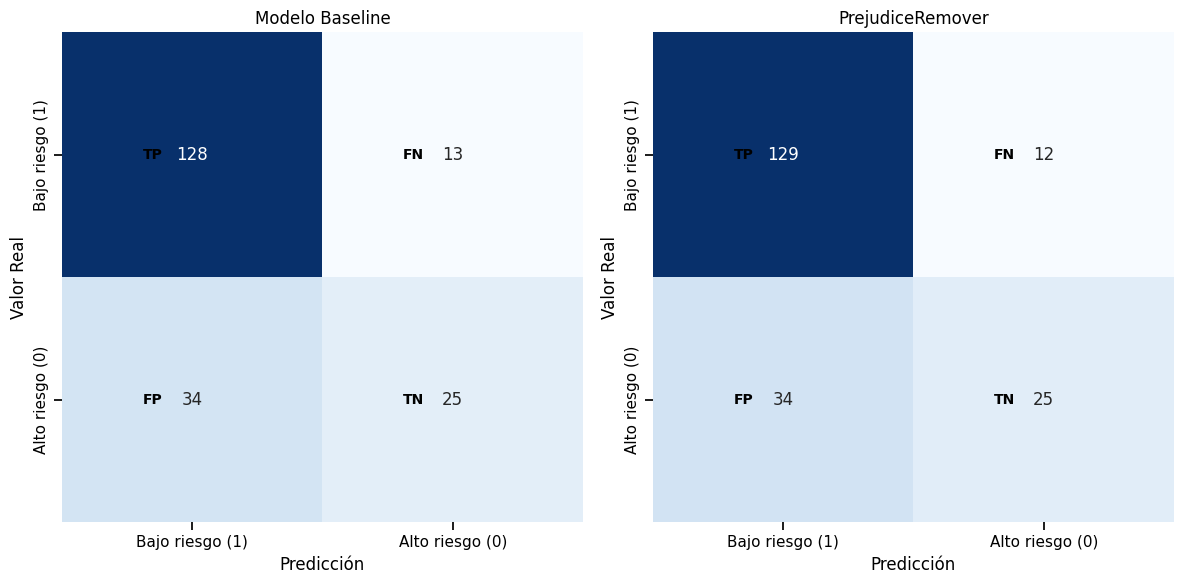

In [42]:
graficar_matrices_de_confusion(
    {"Modelo Baseline": confusion_matrix(y_test, y_pred_test, labels=[1, 0]),
     "PrejudiceRemover": confusion_matrix(
        y_test, y_pred_test_prejud_remover, labels=[1, 0]
    )},
    n_cols=2,
    size=(12, 6)
)

In [43]:
keys = ["Baseline", "CorrelationRemover", "PrejudiceRemover", "Reference"]
comparison = pd.concat(
    [
        baseline_metrics["Value"],
        metrics_preprocessing_correlation_remover["Value"],
        metrics_prejud_remover,
    ],
    axis=1,
)
comparison.columns = keys


def highlight_closest(s):
    reference = s["Reference"]
    differences = s.drop("Reference").apply(lambda x: abs(x - reference))
    closest = differences.idxmin()
    return ["background-color: mediumseagreen" if x == s[closest] else "" for x in s]


comparison_highlighted = comparison.style.apply(highlight_closest, axis=1)
comparison_highlighted

,Baseline,CorrelationRemover,PrejudiceRemover,Reference
Metric,,,,
Statistical Parity,0.083333,-0.097222,-0.033730,0
Disparate Impact,1.111111,0.888889,0.959811,1
Four Fifths Rule,0.900000,0.888889,0.959811,1
Cohen D,0.213470,-0.246777,-0.086919,0
2SD Rule,1.348838,-1.558155,-0.551587,0
Equality of Opportunity Difference,0.049774,-0.056561,-0.046757,0
False Positive Rate Difference,0.148459,-0.205882,-0.016807,0
Average Odds Difference,0.099117,-0.131222,-0.031782,0
Accuracy Difference,-0.003968,0.027778,-0.021825,0


### 5.3 Análisis y comparación de mitigadores

- El método **PrejudiceRemover** mostró una mejora más consistente en la mayoría de las métricas de equidad, logrando valores más cercanos al punto de referencia en Statistical Parity, Disparate Impact y Average Odds Difference.
- Al disminuir significativamente el modulo de la diferencia de FPR, este nuevo modelo cumple con Equalized Odds para un umbral de 0.1.
- El desempeño general del modelo mitigado se mantiene adecuado, con una exactitud del 79%. Sin embargo, persiste una diferencia en la sensibilidad para las clases: el modelo identifica mejor a los solicitantes de bajo riesgo (sensibilidad alta) que a los de alto riesgo.
- La mitigación del sesgo es posible sin sacrificar el desempeño global del modelo, aunque se recomienda seguir explorando técnicas y ajustando hiperparámetros para lograr un balance óptimo entre equidad y precisión.

In [44]:
# SEPARADOR ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# BORRAR PARA ENTREGA FINAL
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ACÁ EMPIEZA LO QUE PERTENECE AL ARCHIVO 06_evaluacion_final_fairness.ipynb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~